# `Clustering Assignment`

##  <p style="color:red">1. Read and Understand Data</p>

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Read csv file
df1 = pd.read_csv('Country data.csv')
df1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# Shape of Dataset
df1.shape

(167, 10)

In [4]:
# Statistic info of Dataset
df1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


##  <p style="color:red">2. Data Cleaning and Visualising</p>

In [5]:
# Check null value in Dataset
df1.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

- There are no null values in data

In [6]:
# Column names
column_name = list(df1.columns)
column_name

['country',
 'child_mort',
 'exports',
 'health',
 'imports',
 'income',
 'inflation',
 'life_expec',
 'total_fer',
 'gdpp']

- We can see from data dictionary that exports, health, imports columns are % of gdpp.

In [7]:
# Convert columns to their original form
df1.exports = df1.exports * df1.gdpp / 100
df1.health = df1.health * df1.gdpp / 100
df1.imports = df1.imports * df1.gdpp / 100
df1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### Univariate Analysis

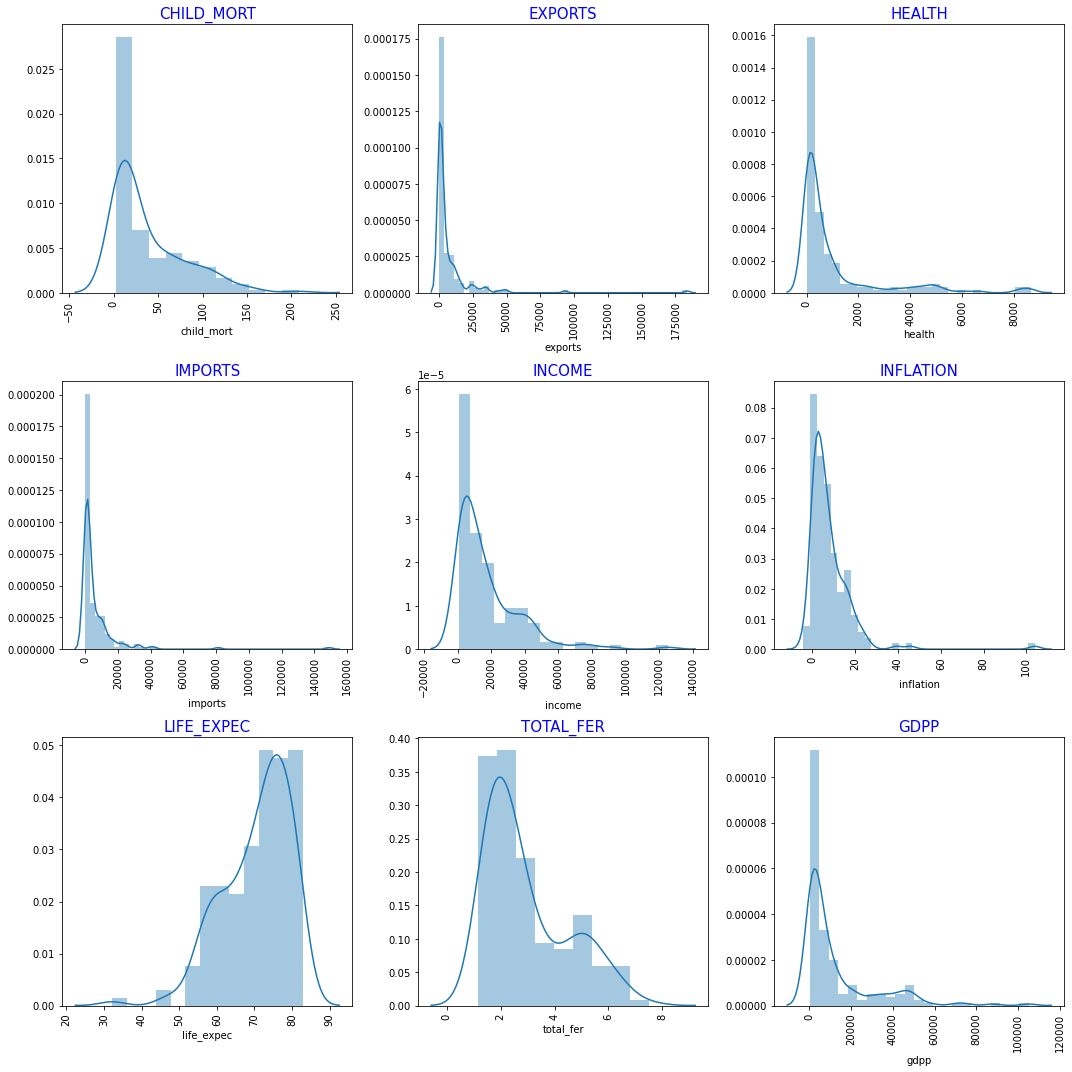

In [8]:
# Distribution-plot
plt.figure(figsize=[15,15])

for i in range(1,len(column_name)):
    plt.subplot(3,3,i)
    sns.distplot(df1[column_name[i]])
    plt.title(column_name[i].upper(), fontdict={'color':'blue', 'size':15})
    plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

- Most of graphs are Normally Distributed.
- We noticed some grouping in `LIFE_EXPEC, TOTAL-FER and GDPP`.

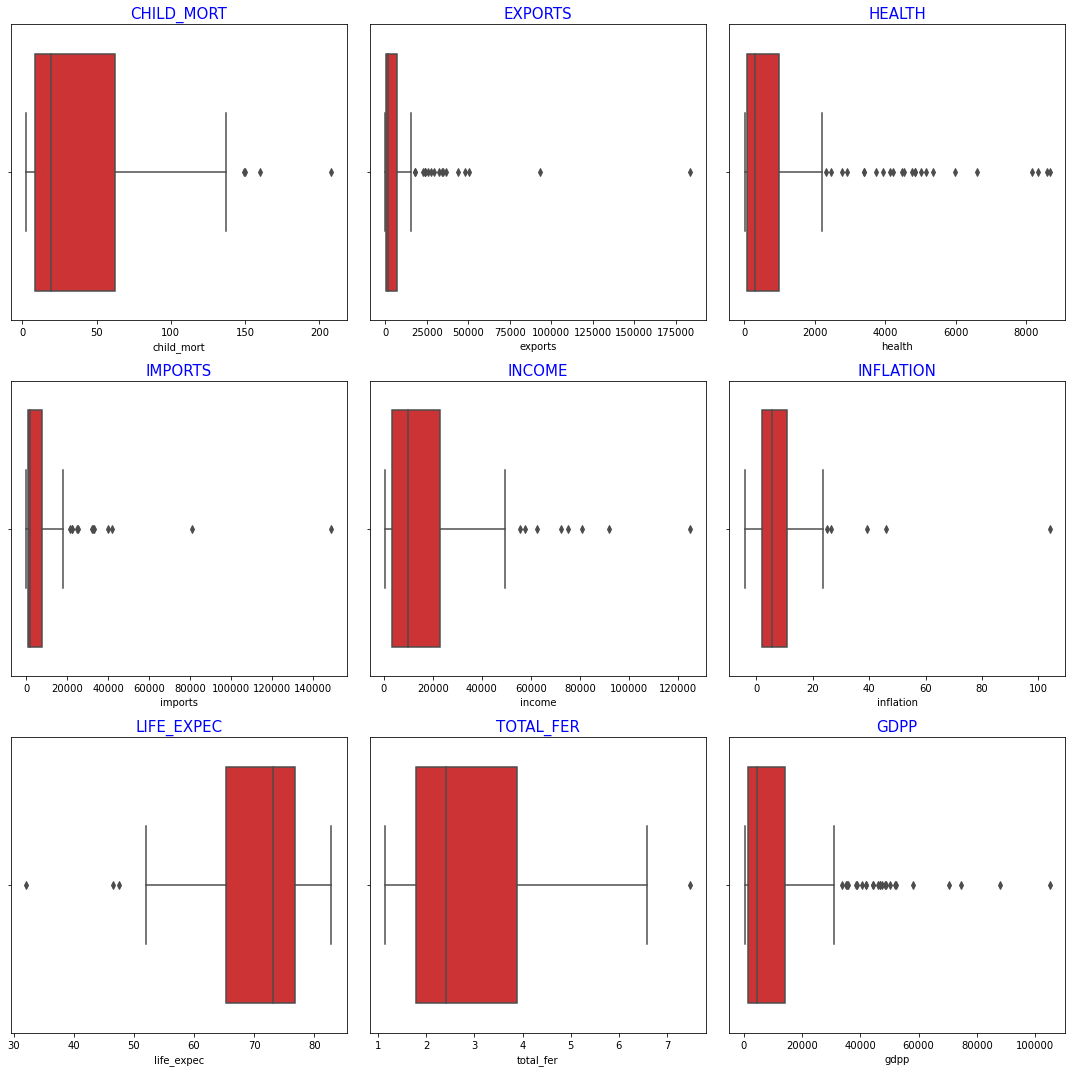

In [9]:
# Boxlplot
plt.figure(figsize=[15,15])

for i in range(1,len(column_name)):
    plt.subplot(3,3,i)
    sns.boxplot(df1[column_name[i]], palette='Set1')
    plt.title(column_name[i].upper(), fontdict={'color':'blue', 'size':15})

plt.tight_layout()
plt.show()

- There are some outliers. We will treat them in later part.

### Bivariate Analysis

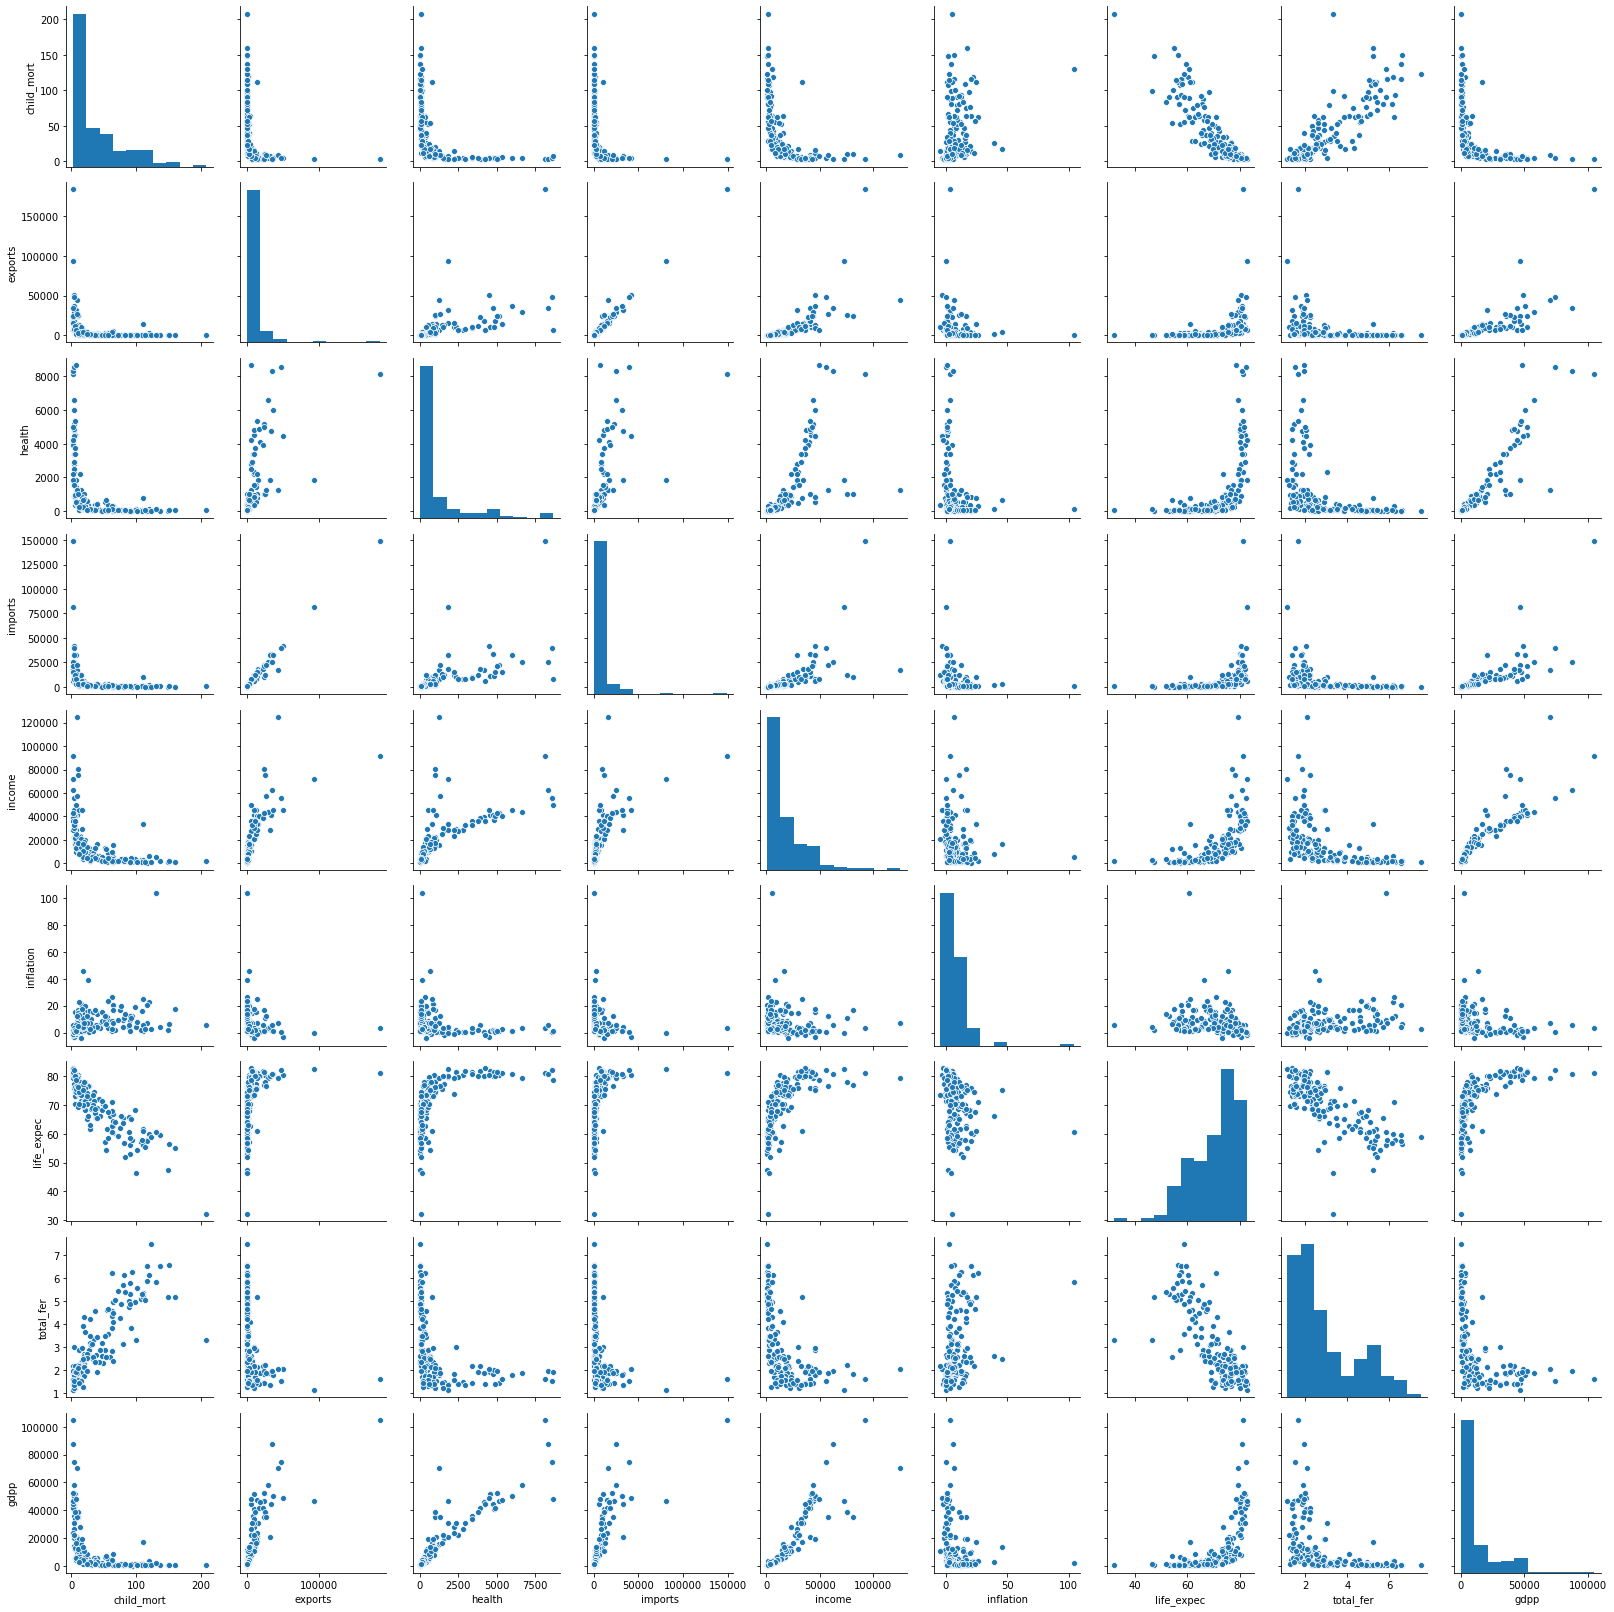

In [10]:
# Pairplot
sns.pairplot(df1[column_name[1:]], palette='Set1')
plt.tight_layout()
plt.show()

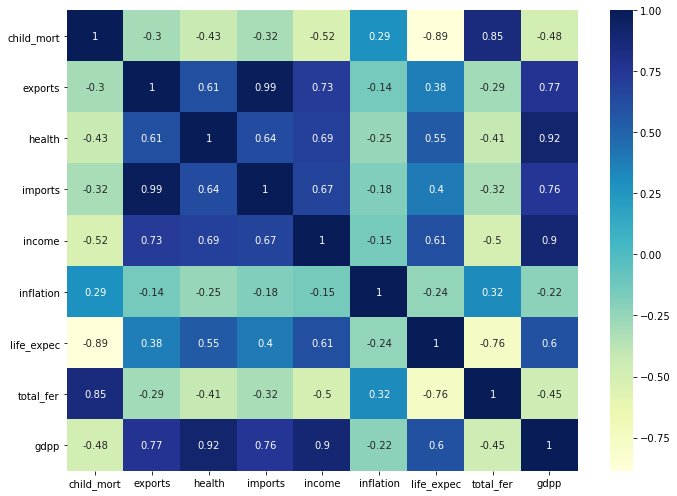

In [11]:
# Heatmap
plt.figure(figsize=[10,7])
sns.heatmap(df1.drop('country', axis=1).corr(), cmap='YlGnBu', annot=True)
plt.tight_layout()
plt.show()

- We found strong Correction between `gdpp-health`, `gdpp-income`, `life_expec-child_mort`, `imports-exports`.

##  <p style="color:red">3. Data Preparation</p>

### Removing Statistical Outliers

We will use Z-Score method for Outlier Detection

In [12]:
# Create Z values
mean = np.mean(df1)
std = np.std(df1)

Z_Score = (df1.iloc[:,1:] - mean) / std

In [13]:
# Finding Outliers
Z_Score = (Z_Score > 3) | (Z_Score < -3)
Z_Score['outlier_status'] = Z_Score.sum(axis=1) > 0
Z_Score.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,outlier_status
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [14]:
# Count outliers
Z_Score.outlier_status.value_counts()

False    153
True      14
Name: outlier_status, dtype: int64

In [15]:
df1[(Z_Score.outlier_status == True)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
23,Brunei,10.5,23792.200,1002.5200,9884.000,80600,16.700,77.1,1.84,35300
44,Denmark,4.1,29290.000,6612.0000,25288.000,44000,3.220,79.5,1.87,58000
66,Haiti,208.0,101.286,45.7442,428.314,1500,5.450,32.1,3.33,662
82,Kuwait,10.8,25679.500,1012.5500,11704.000,75200,11.200,78.2,2.21,38500
91,Luxembourg,2.8,183750.000,8158.5000,149100.000,91700,3.620,81.3,1.63,105000
112,Niger,123.0,77.256,17.9568,170.868,814,2.550,58.8,7.49,348
113,Nigeria,130.0,589.490,118.1310,405.420,5150,104.000,60.5,5.84,2330
114,Norway,3.2,34856.600,8323.4400,25023.000,62300,5.950,81.0,1.95,87800
123,Qatar,9.0,43796.900,1272.4300,16731.400,125000,6.980,79.5,2.07,70300
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.200,55.0,5.20,399


- `Haiti, Niger, Sierra Leone, Nigeria` have `low gdp` and `high child_mort`. So, we can't consider them as outliers.

- Otherwise Every outliers have `Very high income`, `Very high gdpp` and `Low child_mort` values. So, they don't need an aid. We can drop them for better accuracy.

In [16]:
# Removing outliers
new_df = df1[(Z_Score.outlier_status == False) | df1.country.isin(['Haiti','Niger','Sierra Leone','Nigeria'])]
new_df.reset_index(drop='index', inplace=True)

### Rescaling

We will use Standard Scaler for rescaling.

In [17]:
clean_df = new_df.drop('country', axis=1)

In [18]:
# Rescaling
S_S = StandardScaler()
clean_df = pd.DataFrame( S_S.fit_transform(clean_df) )
clean_df.head()

,0,1,2,3,4,5,6,7,8
0,1.228591,-0.612242,-0.588966,-0.636972,-0.937614,0.170911,-1.562285,1.834060,-0.718576
1,-0.581648,-0.470402,-0.420128,-0.385840,-0.305679,-0.307602,0.716162,-0.894462,-0.452589
2,-0.318474,-0.396555,-0.481329,-0.470631,-0.080096,0.814728,0.738833,-0.083103,-0.424764
3,1.936945,-0.333236,-0.545118,-0.454183,-0.611772,1.423745,-1.120198,2.056529,-0.494702
4,-0.736600,0.102970,-0.070639,0.364630,0.390817,-0.602444,0.772839,-0.580388,0.157293


In [19]:
# Assign columns name
clean_df.columns = column_name[1:]
clean_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.228591,-0.612242,-0.588966,-0.636972,-0.937614,0.170911,-1.562285,1.834060,-0.718576
1,-0.581648,-0.470402,-0.420128,-0.385840,-0.305679,-0.307602,0.716162,-0.894462,-0.452589
2,-0.318474,-0.396555,-0.481329,-0.470631,-0.080096,0.814728,0.738833,-0.083103,-0.424764
3,1.936945,-0.333236,-0.545118,-0.454183,-0.611772,1.423745,-1.120198,2.056529,-0.494702
4,-0.736600,0.102970,-0.070639,0.364630,0.390817,-0.602444,0.772839,-0.580388,0.157293


### Hopkins Statistics

In [20]:
# Hopkins statistic

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [21]:
# Hopkins Statistic Value
hopkins(new_df.drop('country', axis=1))

0.9344647167809692

- Hopkins statistic value confirms there is a good cluster tendency.

##  <p style="color:red">4. K-Means Clustering</p>

### Silhouette Score

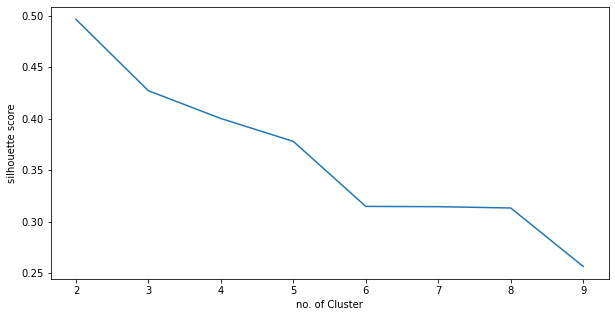

In [22]:
# We'll do the silhouette score analysis
s_s = []

for k in range(2,10):
    kmeans = KMeans(n_clusters = k).fit(clean_df)
    s_s.append( [ k, silhouette_score(clean_df, kmeans.labels_) ] )

plt.figure(figsize=[10,5])

sns.lineplot(pd.DataFrame(s_s)[0], pd.DataFrame(s_s)[1])
plt.xlabel('no. of Cluster')
plt.ylabel('silhouette score')

plt.show()

### Elbow Curve

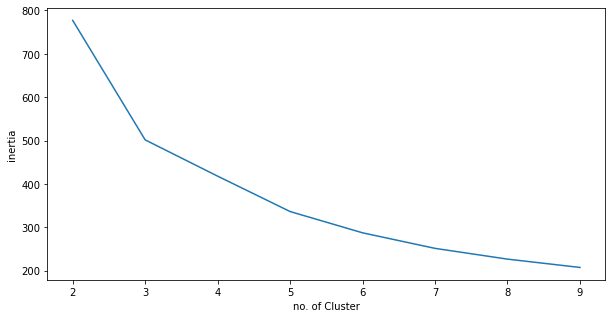

In [23]:
# Elbow curve method
e_c = []

for k in list(range(2,10)):
    model = KMeans(n_clusters = k, max_iter = 50).fit(clean_df)
    e_c.append([k, model.inertia_])

plt.figure(figsize=[10,5])

sns.lineplot(pd.DataFrame(e_c)[0], pd.DataFrame(e_c)[1])
plt.xlabel('no. of Cluster')
plt.ylabel('inertia')

plt.show()

- By looking `silhouette score` and `elbow curve` we should select no. of **cluster = 3**

### Create KMeans Model

In [24]:
# Kmeans model
kmean = KMeans(n_clusters = 3, max_iter = 50, random_state = 50)
kmean.fit(clean_df)

KMeans(max_iter=50, n_clusters=3, random_state=50)

In [25]:
# Display labels
kmean.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 1, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0, 2, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0,
       0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 2, 2,
       1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 1, 2, 0, 1,
       1, 0, 0, 2, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0,
       0, 2, 2], dtype=int32)

In [26]:
# Assign label to country
new_df['cluster_id'] = kmean.labels_
new_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


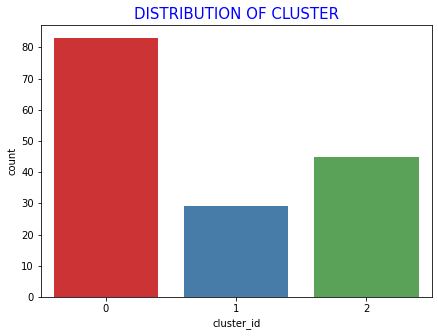

In [27]:
# Countplot of cluster_id
plt.figure(figsize=[7,5])
sns.countplot(new_df.cluster_id, palette='Set1')
plt.title('Distribution of Cluster'.upper(), fontdict={'color':'blue', 'size':15})
plt.show()

In [28]:
# Change data type
new_df = new_df.astype({'cluster_id':'category'})

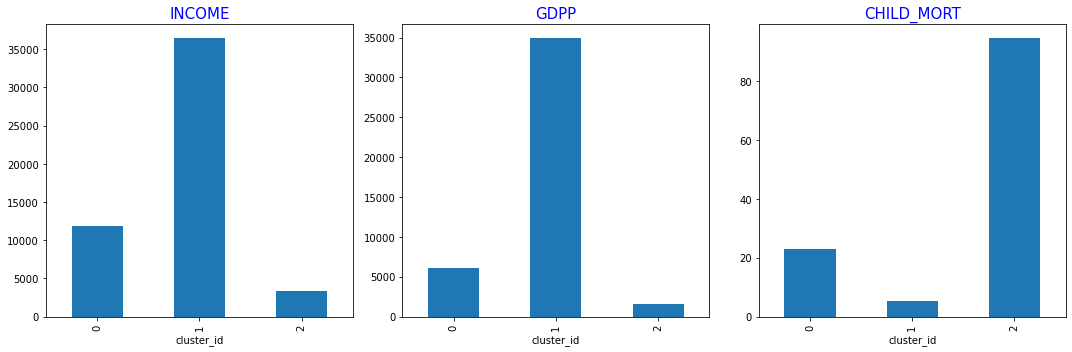

In [29]:
# Barplot for important Attribute's Mean 
plt.figure(figsize=[15,5])

plt.subplot(131)
new_df.groupby('cluster_id')['income'].mean().plot.bar()
plt.title('income'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(132)
new_df.groupby('cluster_id')['gdpp'].mean().plot.bar()
plt.title('gdpp'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(133)
new_df.groupby('cluster_id')['child_mort'].mean().plot.bar()
plt.title('child_mort'.upper(), fontdict={'color':'blue', 'size':15})

plt.tight_layout()
plt.show()

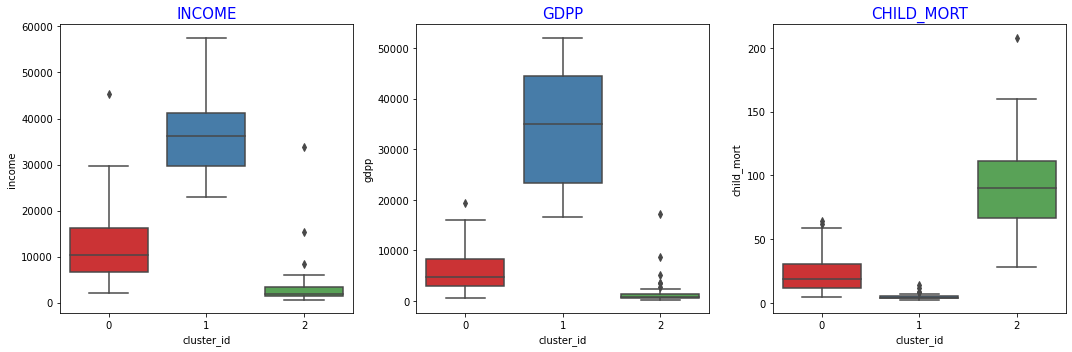

In [30]:
# Boxplot for important attributes 
plt.figure(figsize=[15,5])

plt.subplot(131)
sns.boxplot(new_df.cluster_id, new_df.income, palette='Set1')
plt.title('income'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(132)
sns.boxplot(new_df.cluster_id, new_df.gdpp, palette='Set1')
plt.title('gdpp'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(133)
sns.boxplot(new_df.cluster_id, new_df.child_mort, palette='Set1')
plt.title('child_mort'.upper(), fontdict={'color':'blue', 'size':15})

plt.tight_layout()
plt.show()

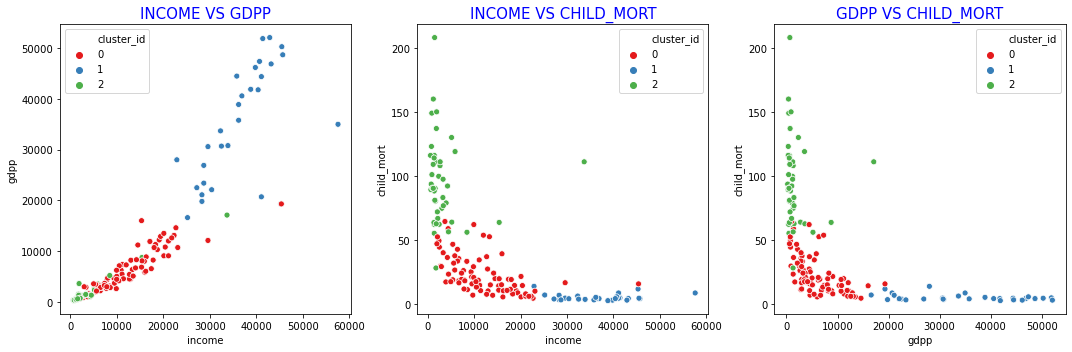

In [31]:
# Scatter-plot for important attributes 
plt.figure(figsize=[15,5])

plt.subplot(131)
sns.scatterplot(new_df['income'], new_df['gdpp'], hue=new_df['cluster_id'], palette='Set1')
plt.title('income vs gdpp'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(132)
sns.scatterplot(new_df['income'], new_df['child_mort'], hue=new_df['cluster_id'], palette='Set1')
plt.title('income vs child_mort'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(133)
sns.scatterplot(new_df['gdpp'], new_df['child_mort'], hue=new_df['cluster_id'], palette='Set1')
plt.title('gdpp vs child_mort'.upper(), fontdict={'color':'blue', 'size':15})

plt.tight_layout()
plt.show()

- Hence from above plot we can see `cluster_id 2` collects data with `low income, low gdpp and high child_mort`.

##  <p style="color:red">5. Hierarchical Clustering</p>

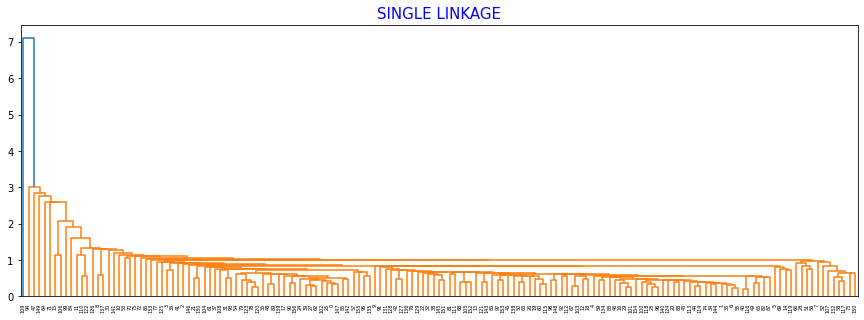

In [32]:
# single linkage
plt.figure(figsize=[15,5])

mergings = linkage(clean_df, method="single", metric='euclidean')
dendrogram(mergings)
plt.title('Single Linkage'.upper(), fontdict={'color':'blue', 'size':15})

plt.show()

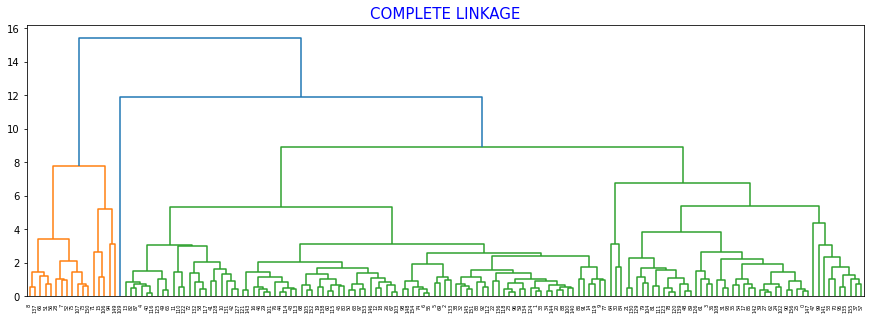

In [33]:
# Complete linkage
plt.figure(figsize=[15,5])
mergings = linkage(clean_df, method="complete", metric='euclidean')
dendrogram(mergings)
plt.title('Complete Linkage'.upper(), fontdict={'color':'blue', 'size':15})

plt.show()

In [34]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=2).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0])

In [35]:
# Assign cluster labels
new_df['cluster_labels'] = cluster_labels
new_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0,0


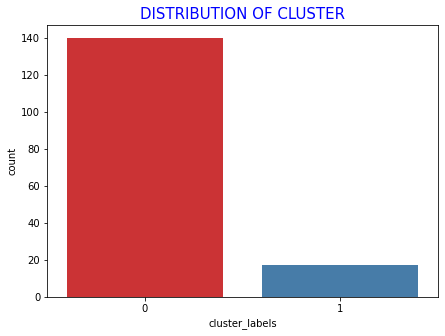

In [36]:
# Countplot of cluster_labels
plt.figure(figsize=[7,5])
sns.countplot(new_df.cluster_labels, palette='Set1')
plt.title('Distribution of Cluster'.upper(), fontdict={'color':'blue', 'size':15})

plt.show()

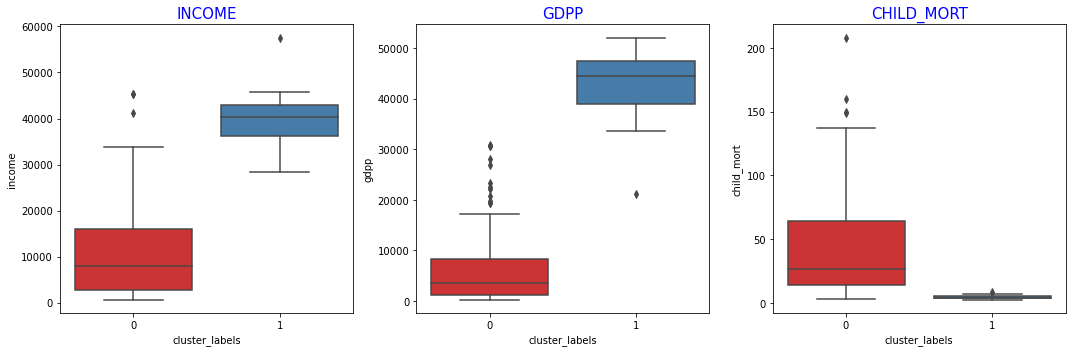

In [37]:
# Boxplot for important attributes 
plt.figure(figsize=[15,5])

plt.subplot(131)
sns.boxplot(new_df.cluster_labels, new_df.income, palette='Set1')
plt.title('income'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(132)
sns.boxplot(new_df.cluster_labels, new_df.gdpp, palette='Set1')
plt.title('gdpp'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(133)
sns.boxplot(new_df.cluster_labels, new_df.child_mort, palette='Set1')
plt.title('child_mort'.upper(), fontdict={'color':'blue', 'size':15})

plt.tight_layout()
plt.show()

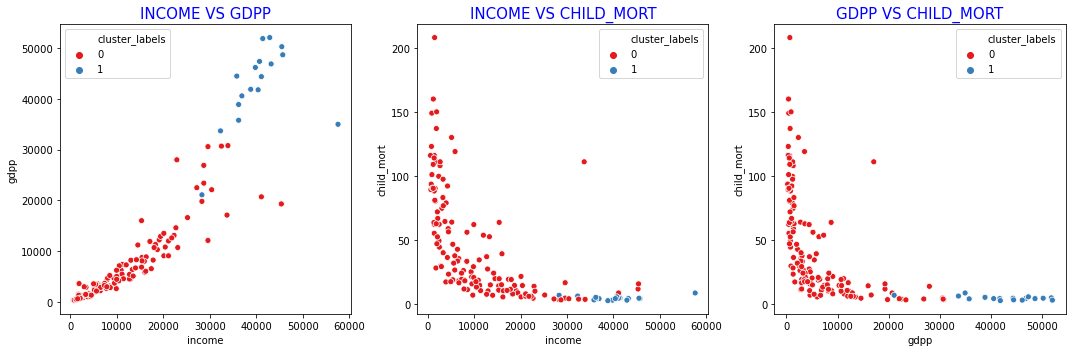

In [38]:
# Scatter-plot for important attributes 
plt.figure(figsize=[15,5])

plt.subplot(131)
sns.scatterplot(new_df['income'], new_df['gdpp'], hue=new_df['cluster_labels'], palette='Set1')
plt.title('income vs gdpp'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(132)
sns.scatterplot(new_df['income'], new_df['child_mort'], hue=new_df['cluster_labels'], palette='Set1')
plt.title('income vs child_mort'.upper(), fontdict={'color':'blue', 'size':15})

plt.subplot(133)
sns.scatterplot(new_df['gdpp'], new_df['child_mort'], hue=new_df['cluster_labels'], palette='Set1')
plt.title('gdpp vs child_mort'.upper(), fontdict={'color':'blue', 'size':15})

plt.tight_layout()
plt.show()

- Hence from above plot we can see `cluster_label 0` collects data with `low income, low gdpp and high child_mort`.

#  <p style="color:green">Top 10 countries from both KMmeans and Hierarchial Clustering method</p>

### Hierarchical 

In [39]:
new_df[new_df.cluster_labels == 0].sort_values(by=['gdpp','child_mort','income'],
                                               ascending=[True,False,True])[['country']].head(10)

,country
25,Burundi
85,Liberia
36,"Congo, Dem. Rep."
108,Niger
126,Sierra Leone
89,Madagascar
102,Mozambique
30,Central African Republic
90,Malawi
48,Eritrea


### KMeans

In [40]:
new_df[new_df.cluster_id == 2].sort_values(by=['gdpp','child_mort','income'],
                                               ascending=[True,False,True])[['country']].head(10)

,country
25,Burundi
85,Liberia
36,"Congo, Dem. Rep."
108,Niger
126,Sierra Leone
89,Madagascar
102,Mozambique
30,Central African Republic
90,Malawi
48,Eritrea


- Both Clustering Methods shows identical top 10 Country Name.

#### TOP 5  COUNTRIES THAT NEED AID ARE MENTIONED BELOW

In [41]:
new_df[new_df.cluster_id == 2].sort_values(by=['gdpp','child_mort','income'],
                                               ascending=[True,False,True])[['country']].head()

,country
25,Burundi
85,Liberia
36,"Congo, Dem. Rep."
108,Niger
126,Sierra Leone
